In [18]:
import joblib
import cv2
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Test pour le SVC

In [19]:

def detect_digits(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits_rois = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if w >= 5 and h >= 25:
            roi = gray[y:y + h, x:x + w]
            digits_rois.append((x, y, w, h, roi))
    return img, digits_rois

def square(img, digits_roi):
    for (x, y, w, h, _) in digits_roi:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    return img
    

def recognize_digits(img, digits_rois, model):
    digits = []
    for (x, y, w, h, roi) in digits_rois:
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = roi / 255.0  # Normalisation simple
        roi = roi.reshape(1, 28*28)  # Aplatir l'image pour correspondre à l'entrée du modèle

        # Utiliser les noms de caractéristiques corrects
        feature_names = [f'pixel{i}' for i in range(1, 28*28 + 1)]
        roi_df = pd.DataFrame(roi, columns=feature_names)

        digit = model.predict(roi_df)
        probabilities = model.predict_proba(roi_df)[0]
        print(f"Digit: {digit[0]}, Probabilities: {probabilities}")

        digit = digit[0]  # Obtenir la prédiction réelle à partir du résultat
        digits.append((x, y, digit, probabilities))
        cv2.putText(img, str(digit), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    
    # Utiliser matplotlib pour afficher l'image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Digits Recognized")
    plt.axis('off')
    plt.show()
    
    return digits


In [20]:
image_path = './data/1_.png'
img, digits_rois = detect_digits(image_path)
img = square(img, digits_rois)
print(digits_rois)

[(464, 183, 132, 631, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))]


Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]


c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


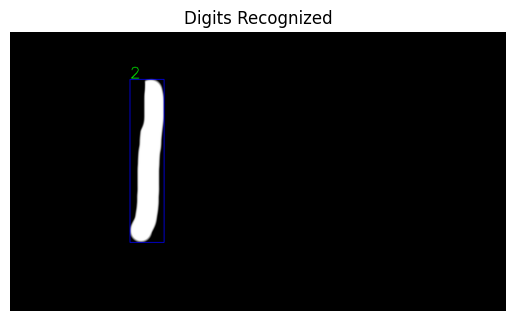

[(464, 183, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.01542108,
       0.11490605, 0.05120658, 0.04213432, 0.06709271, 0.02647215]))]


In [21]:
model = joblib.load('./models/DetectionReconize_optimized2.pkl')
digits = recognize_digits(img, digits_rois, model)
print(digits)

# Test pour le CNN

In [22]:
import cv2
import matplotlib.pyplot as plt

def recognize_digits_cnn(img, digits_rois, model):
    digits = []
    for (x, y, w, h, roi) in digits_rois:
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = roi / 255.0  # Normalisation simple
        roi = roi.reshape(1, 28, 28, 1)  # Reshape pour correspondre à l'entrée du modèle CNN (batch_size, height, width, channels)

        digit = model.predict(roi)
        digit_class = digit.argmax()  # Obtenir la prédiction réelle à partir du résultat
        probabilities = digit[0]  # Obtenir les probabilités

        digits.append((x, y, digit_class, probabilities))
        cv2.putText(img, str(digit_class), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    
    # Utiliser matplotlib pour afficher l'image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Digits Recognized")
    plt.axis('off')
    plt.show()
    
    return digits

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


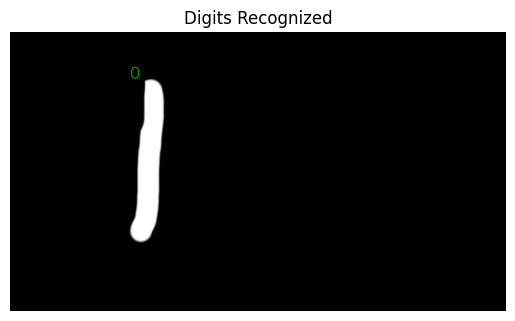

[(464, 183, 0, array([0.8654794 , 0.00225548, 0.00354571, 0.00219552, 0.02073413,
       0.00446359, 0.03090764, 0.00912645, 0.01373307, 0.04755906],
      dtype=float32))]


In [23]:
model_CNN = load_model('./models/DetectionReconize_CNN.h5') # Utiliser load_model pour le modèle CNN
image_path = './data/1_.png'
img, digits_rois = detect_digits(image_path)  
digits_Cnn = recognize_digits_cnn(img, digits_rois, model_CNN)

print(digits_Cnn)